Importing libraries

In [2]:
import json
from collections import defaultdict, Counter
import ast
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import torch
# import torch_geometric as tg
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sentence_transformers import SentenceTransformer

import re
import ast


h:\dev\NLP\GNN_application_in_hate_speech_detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pandas setup

In [4]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed
pd.set_option('display.width', 1000)  # Set max width for table
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

Method for cleaning the data

In [5]:
def clean_special_chars(value):
    if isinstance(value, str):  
        return value.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    return value 

Reading gab

In [6]:
content_gab = pd.read_csv('gab_reddit_benchmark/gab.csv')

content_gab["text"] = content_gab["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab["response"] = content_gab["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab["hate_speech_idx"] = content_gab["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

# content_gab["text"] = content_gab["text"].apply(clean_special_chars)
# content_gab["response"] = content_gab["response"].apply(clean_special_chars)

for index, row in content_gab.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

# content_gab = content_gab.applymap(clean_special_chars)
print(content_gab.head(n=10))
print('\n- - - - - -\n')
print(content_gab.columns)
print('\n- - - - - -\n')
print(content_gab.iloc[1]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0                                    1. 39869714\r\n  1. i joined gab to remind myself how retarded ...         [1]      ["Using words that insult one group while defe...
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  1. This is what the left is really scared of. ...         [3]      ['You can disagree with someones opinion witho...
2                   1. 37485560\r\n2. \t37528625\r\n  1. It makes you an asshole.\r\n2. \tGive it to...         [2]      ['Your argument is more rational if you leave ...
3                   1. 39787626\r\n2. \t39794481\r\n  1. So they manage to provide a whole lot of da...         [2]      ["You shouldn't generalize a specific group or...
4  1. 37957930\r\n2. \t39953348\r\n3. \t\t3996521...  1. Hi there, i,m Keith, i hope you are doing w...         [3]      ['If someone is rude it 

In [7]:
content_gab_m = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
content_gab_m = content_gab_m.drop('Unnamed: 0', axis=1)
content_gab_m = content_gab_m.drop('extracted_id', axis=1)


content_gab_m["text"] = content_gab_m["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab_m["response"] = content_gab_m["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab_m["hate_speech_idx"] = content_gab_m["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

for index, row in content_gab_m.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

print(content_gab_m.head(n=10))
print('\n- - - - - -\n')
print(content_gab_m.columns)
print('\n- - - - - -\n')
print(content_gab_m.iloc[0]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0  1. 37011807\r\n2. \t37012801\r\n3. \t\t3701333...  1. 64% of Hispanics have IQ scores too low to ...     [2, 2, 3]    ['Racist and hate speech will not be tolerated...
1                    1. 37012081\r\n 1. 37012081\r\n  1. LYING CUNT BITCH !!\r\n 1. LYING CUNT BITCH...        [1, 1]    ['Please refrain from using derogatory terms f...
2                                    1. 37012105\r\n  1. Nigger Kills 2 cops https://www.google.com/...           [1]    ['The N word is highly offensive.   All ethnic...
3                   1. 37012146\r\n2. \t37013020\r\n  1. STABBED IN NECK   arrested but no descr   #...           [2]    ['Use of the n-word is unacceptable in our dis...
4  1. 37012285\r\n2. \t37013809\r\n3. \t37013868\r\n  1. Retard 1st Class  w/ Cluster & Ribbon\r\n2....           [1]    ['We should try and not 

In [8]:
def mark_text_labels(text_utterances_length, labels):
    if not labels:
        # return ['other'] * text_utterances_length
        return [0] * text_utterances_length
    new_labels = []
    int_list = ast.literal_eval(labels)
    for i in range(text_utterances_length):
        if i+1 in int_list:
            # new_labels.append('hate_speech')
            new_labels.append(1)
        else:
            # new_labels.append('other')
            new_labels.append(0)
    return new_labels

Splitting 'text' and 'response' into individual rows, so that I can construct a graph from it

In [9]:
text_column = []
text_labels_column = []
response_column = []
response_labels_column = []

for index, row in content_gab.iterrows():
    text_utterances = row['text'].split('\n')
    text_utterances = list(filter(None, text_utterances))

    for i, t in enumerate(text_utterances):
        text_utterances[i] = clean_special_chars(t)
    text_labels = mark_text_labels(len(text_utterances), row['hate_speech_idx'])

    response_utterances = ast.literal_eval(row['response']) if row['response'] else []
    for i, r in enumerate(response_utterances):
        response_utterances[i] = clean_special_chars(r)
    # response_labels = ['other'] * len(response_utterances)  
    response_labels = [0] * len(response_utterances)  

    
    text_column.append(text_utterances)
    text_labels_column.append(text_labels)
    response_column.append(response_utterances)
    response_labels_column.append(response_labels)

content_gab['text'] = text_column
content_gab['hate_speech_idx'] = text_labels_column
content_gab['response'] = response_column
content_gab['response_labels'] = response_labels_column

content_gab = content_gab.rename(columns={'hate_speech_idx': 'text_labels'})
print(content_gab.head())
print('- - - - ')
print(content_gab.columns)

for index, row in content_gab.iterrows():
    if index == 1:
        continue
    print(row['id'])
    print(row['text'])
    print(row['text_labels'])
    print(row['response'])
    print(row['response_labels'])
    break

                          id                                                text                        text_labels                      response                      response_labels
0                                    1. 39869714\r\n  [1. i joined gab to remind myself how retarded...         [1]  [Using words that insult one group while defen...     [0, 0, 0]  
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  [1. This is what the left is really scared of....   [0, 0, 1]  [You can disagree with someones opinion withou...     [0, 0, 0]  
2                   1. 37485560\r\n2. \t37528625\r\n  [1. It makes you an asshole., 2. Give it to a ...      [0, 1]  [Your argument is more rational if you leave y...     [0, 0, 0]  
3                   1. 39787626\r\n2. \t39794481\r\n  [1. So they manage to provide a whole lot of d...      [0, 1]  [You shouldn't generalize a specific group or ...     [0, 0, 0]  
4  1. 37957930\r\n2. \t39953348\r\n3. \t\t3996521...  [1. Hi there, i,m Keith, i hope

Encoding the labels

In [67]:
# label_encoder = LabelEncoder()
# content_gab['all_labels'] = content_gab['text_labels'] + content_gab['response_labels']
# content_gab['all_labels_encoded'] = content_gab['all_labels'].apply(label_encoder.fit_transform)
# print(content_gab.iloc[0])
# content_gab['text_labels_encoded'] = content_gab['text_labels'].apply(label_encoder.fit_transform)
# content_gab['response_labels_encoded'] = content_gab['response_labels'].apply(label_encoder.fit_transform)

Creating BERT encoding method

In [10]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(sentences):
    if isinstance(sentences, list):
        return bert.encode(sentences, show_progress_bar=True).tolist()
    elif isinstance(sentences, str):
        return bert.encode([sentences], show_progress_bar=True).tolist()
    return []

h:\dev\NLP\GNN_application_in_hate_speech_detection\venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Wrobl\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Generating BERT embeddings

In [11]:
content_gab = content_gab[:200]
before = time.time()
content_gab['text_embeddings'] = content_gab['text'].apply(generate_embeddings)
after_text = time.time()
print(content_gab.iloc[1]['text_embeddings'])
print('\nTIME FOR TEXT EMBEDDINGS: ', after_text - before)
print('\n- - - - - -\n')
content_gab['response_embeddings'] = content_gab['response'].apply(generate_embeddings)
after_response = time.time()
print(content_gab.iloc[2]['response_embeddings'])
print('\nTIME FOR RESPONSE EMBEDDINGS: ', after_response - after_text)
print('\n- - - - - -\n')

Batches: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]


[[-0.023572085425257683, 0.017944442108273506, 0.040565647184848785, 0.06729648262262344, 0.09804016351699829, 0.03511403501033783, 0.06723953783512115, -0.07981330156326294, 0.012592197395861149, -0.06395190954208374, 0.014613415114581585, -0.02868604101240635, 0.06557449698448181, -0.05138687416911125, -0.1029239222407341, 0.015551761724054813, -0.06676268577575684, -0.0029045867267996073, -0.027871351689100266, 0.06036287546157837, -0.027235571295022964, 0.02632731758058071, 0.03128807619214058, 0.017424041405320168, 0.013893619179725647, -0.06276202201843262, -0.013789272867143154, -0.015726275742053986, -0.03531144559383392, -0.054763998836278915, 0.013463125564157963, -0.02827640064060688, -0.03120230697095394, -0.05433619022369385, -0.011610044166445732, -0.04129823297262192, 0.10698012262582779, -0.05024966597557068, -0.029813911765813828, 0.062091145664453506, -0.017547206953167915, -0.015013372525572777, 0.08790481090545654, 0.07822362333536148, -0.0915985107421875, 0.0481597

Batches: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]

[[0.09269339591264725, 0.005343963857740164, -0.021850140765309334, -0.0007701202412135899, 0.04873262345790863, 0.028574742376804352, 0.06419852375984192, -0.009560701437294483, 0.053361136466264725, -0.08790569752454758, -0.014494866132736206, -0.001336785382591188, 0.09828134626150131, -0.01316970493644476, 0.03653036430478096, 0.08743909001350403, 0.05540040507912636, 0.0015357804950326681, -0.03637179359793663, 0.008946479298174381, -0.08317054063081741, 0.093168705701828, -0.04679816961288452, -0.02023383602499962, -0.04995940253138542, -0.041779037564992905, -0.015589887276291847, 0.03397413715720177, -0.014390932396054268, 0.10862997174263, 0.020122425630688667, -0.01385401375591755, 0.046556368470191956, 0.014802731573581696, 0.0009073873516172171, -0.003735911101102829, 0.007216203957796097, 0.047422852367162704, 0.015439030714333057, 0.013636776246130466, 0.012506699189543724, 0.008980418555438519, -0.0021204580552875996, -0.07505076378583908, -0.0013401039177551866, -0.0007

Graphs from words

In [12]:
for texts in content_gab['text']:
    for sentence in texts:
        words = sentence.split()
        words.pop(0)
        print(words)


['i', 'joined', 'gab', 'to', 'remind', 'myself', 'how', 'retarded', 'jew', 'haters', 'are.', 'You', "wouldn't", 'be', 'typing', 'on', 'your', 'abacus', 'without', 'them', 'you', 'retard.']
['This', 'is', 'what', 'the', 'left', 'is', 'really', 'scared', 'of.', 'https://redd.it/9rfkts']
['That', 'literally', 'looks', 'like', 'a', 'monkey.', 'Why', 'are', 'we', 'supposed', 'to', 'pretend', 'it’s', 'a', 'person', 'bc', 'it’s', 'wearing', 'a', 'red', 'hat?']
['Dumb', 'Cunt']
['It', 'makes', 'you', 'an', 'asshole.']
['Give', 'it', 'to', 'a', 'soldier', 'who', 'has', 'defend', 'it', ',', 'then', 'try', 'to', 'burn', 'it', '.', 'Show', 'me', 'what', 'a', 'badass', 'you', 'really', 'are.', 'The', 'flag', 'is', 'helpless', 'to', 'stop', 'you', 'or', 'fight', 'back', '.', 'Completely', 'unnecessary', 'act', ',', 'its', 'proves', 'nothing', 'and', 'accomplishes', 'nothing.', 'It', 'only', 'shows', 'your', 'a', 'ignorant', 'weak', 'faggot', '.', 'Like', 'kicking', 'a', 'puppy', ',,,', 'it', 'shows'

In [13]:
import pandas as pd
from torch_geometric.data import Data


# Function to construct a graph for a single sentence
def construct_graph_words(sentence, label):
    # Split sentence into words and remove the first word
    words = sentence.split()[1:]

    # Create nodes (word embeddings, or simple indices for now)
    nodes = list(range(len(words)))

    # Create edges (sequential connections: i -> i+1)
    edges = [(i, i+1) for i in range(len(words)-1)]  # Directed edges
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Convert nodes to tensor
    x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)  # Example: 1D feature per node

    # Create the graph
    graph = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    return graph

# Process each sentence in the DataFrame
graphs_words = []
for index, row in content_gab.iterrows():
    for sentence, label in zip(row['text'], row['text_labels']):
        if len(sentence.split()[1:]) > 0:
            graph = construct_graph_words(sentence, label) 
            graphs_words.append(graph)



Given percentage of shuffled dataset is test fold

In [14]:
random.shuffle(graphs_words)

size_train = len(graphs_words) - len(graphs_words) // 10 # 10% test dataset

train_dataset = graphs_words[:size_train]
test_dataset = graphs_words[size_train:]
print(len(train_dataset))
print(len(test_dataset))

504
55


Cross-validation 

In [73]:
#y = []
#for index, row in content_gab.iterrows():
#    y.append(np.concatenate((row['text_labels'], row['response_labels'])).astype(int))

#for i, q in enumerate(y):
#    print(q)
#    if i >= 5:
#       print('\n- - - -')
#       break
#for i, q in enumerate(graphs):
#    print(q)
#    if i >= 5:
#       break

#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=36851234)
#folds = list(rskf.split(graphs, y))

Mini-batching of graphs

In [15]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1360, 1], edge_index=[2, 1296], y=[64], batch=[1360], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1514, 1], edge_index=[2, 1450], y=[64], batch=[1514], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[2304, 1], edge_index=[2, 2240], y=[64], batch=[2304], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[1483, 1], edge_index=[2, 1419], y=[64], batch=[1483], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[1553, 1], edge_index=[2, 1489], y=[64], batch=[1553], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[1330, 1], edge_index=[2, 1266], y=[64], batch=[1330], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[1459, 1], edge_index=[2, 1395], y=[64], batch=[1459], ptr=[65])

Step 8:
Number of graphs in the current batch: 56
DataBatch(x=[1241, 1], edge_index=[2, 1185], y=[56], b

Graphs from words classification

In [16]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

num_classes = 2
input_dim = graphs_words[0].x.shape[1]


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.5000, Test Acc: 0.4182
Epoch: 002, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 003, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 004, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 005, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 006, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 007, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 008, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 009, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 010, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 011, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 012, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 013, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 014, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 015, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 016, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 017, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 018, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 019, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 020, Train Acc: 0.5873, Test Acc: 0.6909
Epoch: 021, Train Acc: 0.5873, Test Acc:

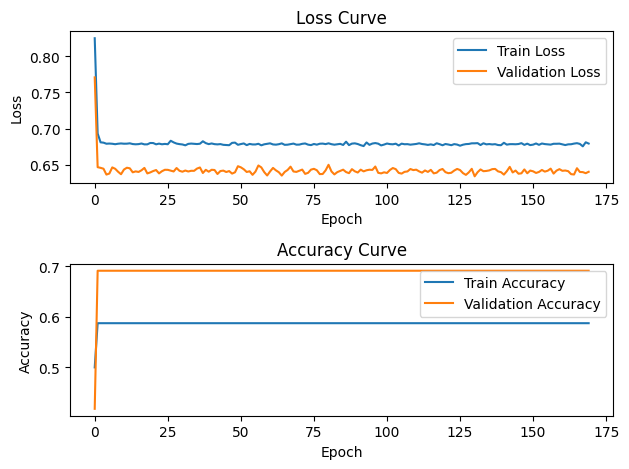

In [17]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
epoch_num = 171

def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y)  # Compute the loss.
            total_loss += loss.item()  # Accumulate batch loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            
    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)  # Append training loss to the list
            
         

def test(loader):
     model.eval()

     correct = 0
     total_loss = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.batch)  
            loss = criterion(out, data.y)  # Compute the loss.
            total_loss += loss.item()  # Accumulate batch loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     test_acc = correct / len(loader.dataset)
     avg_loss = total_loss / len(loader)  # Compute average loss.
     return test_acc, avg_loss  # Derive ratio of correct predictions.


for epoch in range(1, epoch_num):
    train()
    train_acc, train_loss = test(train_loader)
    test_acc, test_loss = test(test_loader)
    val_acc_list.append(test_acc)     # Append validation accuracy to the list
    train_acc_list.append(train_acc)    # Append training accuracy to the list
    val_loss_list.append(test_loss)  # Append validation loss to the list
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


# Plot learning curve
plt.subplot(2,1,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(2,1,2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()